In [9]:
#Import librerie
import os
from pathlib import Path
import numpy as np
from PIL import Image
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.segmentation import fcn_resnet50

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as TF

In [10]:
#Configurazioni
base_path = "/kaggle/input/d/awsaf49/coco-2017-dataset/coco2017"
train_img_dir = os.path.join(base_path, "train2017")
train_ann_file = os.path.join(base_path, "annotations/instances_train2017.json")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Dimensione del dataset
NUM_IMG=100

#Hyperparameters
SIZE=1024
IMG_SIZE = (1024, 1024)
BATCH_SIZE = 2
NUM_WORKERS = 4
LR = 4.4e-4
NUM_EPOCHS = 20

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

#Loss
criterion = nn.CrossEntropyLoss()

# Max batches per la validation
MAX_BATCHES = 500

In [11]:
coco = COCO(train_ann_file)
cat_ids = sorted(coco.getCatIds()) 
cat2label = {cat_id: idx+1 for idx, cat_id in enumerate(cat_ids)}

NUM_CLASSES = len(cat_ids) + 1 
print("NUM_CLASSES (including background):", NUM_CLASSES)

loading annotations into memory...
Done (t=15.94s)
creating index...
index created!
NUM_CLASSES (including background): 81


In [12]:
#DatasetCustom
class COCOSegmentationDataset(Dataset):
    def __init__(self, img_dir, coco, cat2label, target_size=(SIZE,SIZE)):
        self.img_dir = img_dir
        self.coco = coco
        self.ids = coco.getImgIds()
        self.cat2label = cat2label
        self.target_size = target_size

    def _build_mask(self, anns, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        anns = sorted(anns, key=lambda a: a["area"], reverse=True)
        for ann in anns:
            m = self.coco.annToMask(ann)
            label = self.cat2label[ann["category_id"]]
            mask[m > 0] = label
        return mask

    def _resize_(self, img, target_size, resample):
        tw, th = target_size
        w, h = img.size
        scale = min(tw / w, th / h)
        nw, nh = int(w * scale), int(h * scale)
        img = img.resize((nw, nh), resample)
        canvas = Image.new(img.mode, (tw, th), 0)
        canvas.paste(img, ((tw - nw)//2, (th - nh)//2))
        return canvas

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        img = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = Image.fromarray(self._build_mask(anns, info["height"], info["width"]))

        # Resize 
        img = self._resize_(img, self.target_size, Image.BILINEAR)
        mask = self._resize_(mask, self.target_size, Image.NEAREST)

        img = TF.to_tensor(img)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return img, mask

    def __len__(self):
        return len(self.ids)

In [13]:
full_dataset = COCOSegmentationDataset(train_img_dir, coco, cat2label, target_size=IMG_SIZE)
small_subset = torch.utils.data.Subset(full_dataset, list(range(min(NUM_IMG, len(full_dataset)))))
num_samples = len(small_subset)
num_train = int(num_samples*0.8)
num_val = num_samples - num_train
train_set, val_set = torch.utils.data.random_split(small_subset, [num_train, num_val])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Train:", len(train_set))
print("Val:", len(val_set))

Train: 80
Val: 20


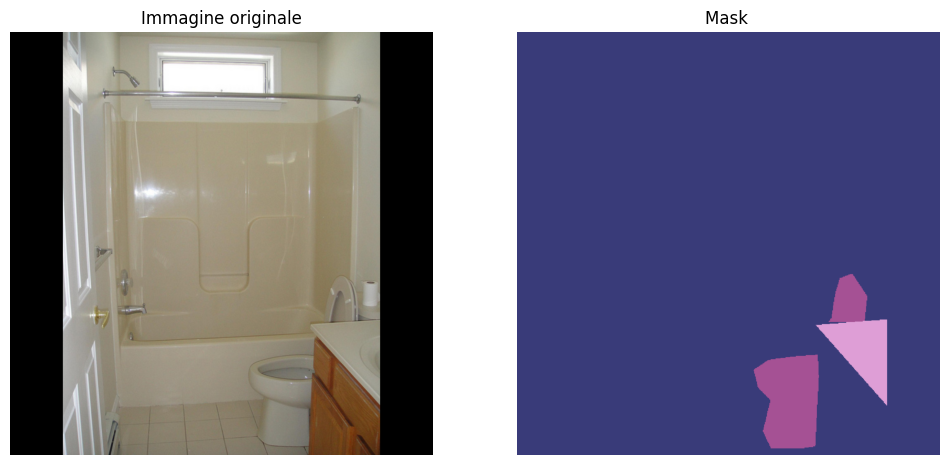

In [14]:
def show_gt_sample(dataset, idx):
    img, mask = dataset[idx]
    img_np = img.permute(1, 2, 0).numpy()

    num_classes = mask.max().item() + 1 

    # Colormap 
    cmap = plt.get_cmap("tab20b", num_classes) 
    mask_color = cmap(np.arange(num_classes) / (num_classes - 1))[:, :3] 
    mask_color = (mask_color * 255).astype(np.uint8)
    mask_color[1] = np.array([255, 0, 0], dtype=np.uint8) #Color-mask rossa per persone 
    mask_rgb = mask_color[mask.numpy()]

    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Immagine originale")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask_rgb)
    plt.title("Mask ")
    plt.axis("off")

    plt.show()


show_gt_sample(small_subset, random.randint(0, len(small_subset)-1))

In [15]:
# Model: FCN-ResNet50 from scratch
model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)

# Otimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [16]:
# 10 learning rate  tra 1e-3 e 1e-5

#lr_values = np.logspace(-2, -5, 10)
#print("Learning rates:", lr_values)
#results_train_loss = []
#results_val_loss = []

#for lr in lr_values:
    #print(f"  Addestramento completo con LR = {lr:.6e}")
    #model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)
    #optimizer = optim.Adam(model.parameters(), lr=lr)

    #best_train_loss = None
    #best_val_loss = None

    #for epoch in range(1, NUM_EPOCHS + 1):
        # TRAIN 

        #model.train()
        #running_train_loss = 0.0
        #pbar = tqdm(train_loader, desc=f"LR={lr:.1e} | Epoch {epoch}/{NUM_EPOCHS}")
        #for i, (imgs, masks) in enumerate(pbar, 1):
            #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

            #optimizer.zero_grad()
            #outputs = model(imgs)["out"]
            #loss = criterion(outputs, masks)
            #loss.backward()
            #optimizer.step()

            #running_train_loss += loss.item()
            #avg_train_loss = running_train_loss / i
            #pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}")

        #VALIDATION 

        #model.eval()
        #running_val_loss = 0.0
        #with torch.no_grad():
            #for imgs, masks in val_loader:
                #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                #outputs = model(imgs)["out"]
                #loss = criterion(outputs, masks)
                #running_val_loss += loss.item()

        #avg_val_loss = running_val_loss / len(val_loader)

        #print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

        # Salvataggio miglior loss lungo le epoche
        #if best_train_loss is None or avg_train_loss < best_train_loss:
         #   best_train_loss = avg_train_loss
        #if best_val_loss is None or avg_val_loss < best_val_loss:
         #   best_val_loss = avg_val_loss

    
    #results_train_loss.append(best_train_loss)
    #results_val_loss.append(best_val_loss)

    #print(f"--> LR={lr:.1e} | best_train_loss={best_train_loss:.4f}, best_val_loss={best_val_loss:.4f}")

    # libero memoria GPU prima di passare al prossimo LR
    #del model, optimizer
    #torch.cuda.empty_cache()

#plt.figure(figsize=(8,5))

#plt.semilogx(lr_values, results_val_loss, marker="o", label="Best Validation Loss")
#plt.semilogx(lr_values, results_train_loss, marker="x", linestyle="--", label="Best Train Loss")

#plt.xlabel("Learning Rate")
#plt.ylabel("Loss")
#plt.title("Sweep Learning Rate [1e-2, 1e-5]")
#plt.grid(True, which="both")
#plt.legend()
#plt.show()

In [ ]:
train_losses = []
val_losses = []

best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):

    # Training
    model.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for i, (imgs, masks) in enumerate(pbar, 1):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        out = model(imgs)["out"]
        loss = criterion(out, masks)
        loss.backward()
        optimizer.step()

        running_train += loss.item()
        pbar.set_postfix(loss=running_train / i)

    train_losses.append(running_train / len(train_loader))

    # Validation
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            out = model(imgs)["out"]
            loss = criterion(out, masks)
            running_val += loss.item()

    avg_val = running_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1} Train {train_losses[-1]:.4f}, Val {avg_val:.4f}")

    scheduler.step()

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print("Salvato best model")

Epoch 1/20: 100%|██████████| 40/40 [00:42<00:00,  1.06s/it, loss=2.05]


Epoch 1 Train 2.0492, Val 57.6502
Salvato best model


Epoch 2/20: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.944]


Epoch 2 Train 0.9437, Val 1.1621
Salvato best model


Epoch 3/20:  78%|███████▊  | 31/40 [00:32<00:09,  1.03s/it, loss=0.773]

In [ ]:
#Grafico 
loss_name = criterion.__class__.__name__
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss ({loss_name})")
plt.legend()
plt.grid()
plt.show()

# Salvataggio dinamico in base alla loss

filename = f"loss_plot_{loss_name}.png"

plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

print(f"Grafico salvato come: {filename}")

In [ ]:
#Risultati
#def pixel_acc(pred, gt):
#    valid = (gt >= 0)
#    return (pred[valid] == gt[valid]).sum().item() / valid.sum().item()
#
#model.eval()
#with torch.no_grad():
#    accs = []
#    for i in range(10):
#        img, gt = full_dataset[i]
#        inp = img.unsqueeze(0).to(DEVICE)
#        out = model(inp)["out"].argmax(1).squeeze(0).cpu()
#        accs.append(pixel_acc(out, gt))
#    print("Mean pixel accuracy (first 10):", float(np.mean(accs))

In [ ]:
def visualize_sample(
    dataset,
    model,
    index=0,
    num_classes=NUM_CLASSES,
    person_class_index=1,
    save=True,
    out_dir="/kaggle/working"
):
    # Recupera nome della loss una sola volta
    loss_name = criterion.__class__.__name__

    model.eval()
    img, gt_mask = dataset[index]
    inp = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(inp)["out"].argmax(1).squeeze(0).cpu().numpy()

    img_np = img.permute(1, 2, 0).cpu().numpy()
    gt_np = gt_mask.numpy()

    # Colormap
    cmap_base = plt.get_cmap("tab20")
    mask_color = (cmap_base(np.arange(num_classes) / max(num_classes-1, 1))[:, :3] * 255).astype(np.uint8)
    if person_class_index < num_classes:
        mask_color[person_class_index] = np.array([255, 0, 0], dtype=np.uint8)

    def mask_to_rgb(mask):
        h, w = mask.shape
        rgb = np.zeros((h, w, 3), dtype=np.uint8)
        for i in range(num_classes):
            rgb[mask == i] = mask_color[i]
        return rgb

    gt_rgb = mask_to_rgb(gt_np)
    pred_rgb = mask_to_rgb(pred)

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(img_np)
    plt.title("Immagine originale")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(gt_rgb)
    plt.title("Maschera GT")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(pred_rgb)
    plt.title(f"Predizione FCN ({loss_name})")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(img_np)
    plt.imshow(pred_rgb, alpha=0.5)
    plt.title("Overlay immagine + predizione")
    plt.axis("off")

    plt.tight_layout()

    # Salvataggio
    if save:
        filename = f"{out_dir}/sample_{index}_loss_{loss_name}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Figura salvata in: {filename}")

    plt.show()

# Uso
index = random.randint(0, len(small_subset) - 1)
visualize_sample(small_subset, model, index)

In [ ]:
loss_name = criterion.__class__.__name__
# ----------------------
#     METRICHE FINALI
# ----------------------

# IoU per classe
IoU_perclass = intersection / (union + 1e-9)
mIoU = float(IoU_perclass.mean())   # MEDIA SU TUTTE LE CLASSI

# F1-score per classe
F1_perclass = (2 * TP) / (2 * TP + FP + FN + 1e-9)
F1_macro = float(F1_perclass.mean())   # MEDIA SU TUTTE LE CLASSI

# Nome della loss
loss_name = criterion.__class__.__name__

print("\n===== RISULTATI FINALI =====")
print(f"mIoU (macro su tutte le classi): {mIoU:.4f}")
print(f"F1-score (macro su tutte le classi): {F1_macro:.4f}")

print("\n📈 IoU per classe:")
for i in range(NUM_CLASSES):
    print(f"Classe {i}: IoU = {IoU_perclass[i]:.4f}")

print("\n📈 F1 per classe:")
for i in range(NUM_CLASSES):
    print(f"Classe {i}: F1 = {F1_perclass[i]:.4f}")

out_dir = "/kaggle/working"


# -------------------------------------
# 🔥 CONFUSION MATRIX CON NOME LOSS 🔥
# -------------------------------------

plt.figure(figsize=(12,10))
plt.imshow(np.log1p(conf_matrix), cmap="viridis")  # log per vedere meglio
plt.colorbar(label="log(pixel count)")
plt.title(f"Confusion Matrix (log scalata, loss = {loss_name})")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.tight_layout()

cm_path = f"{out_dir}/confusion_matrix_{loss_name}.png"
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
print(f"\n[Salvato] Confusion matrix: {cm_path}")
plt.show()


# -------------------------------------
# 📊 ISTOGRAMMA mIoU vs F1 MACRO
# -------------------------------------

plt.figure(figsize=(6,5))
metrics_names = ["mIoU", "F1 macro"]
metrics_vals  = [mIoU, F1_macro]

plt.bar(metrics_names, metrics_vals)
plt.ylim(0, 1.0)
plt.ylabel("Valore")
plt.title(f"mIoU e F1 macro (loss = {loss_name})")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

macro_path = f"{out_dir}/macro_metrics_{loss_name}.png"
plt.savefig(macro_path, dpi=300, bbox_inches="tight")
print(f"[Salvato] Istogramma macro (mIoU/F1): {macro_path}")
plt.show()


# -------------------------------------
# 📊 ISTOGRAMMA IoU PER CLASSE
# -------------------------------------

plt.figure(figsize=(12,5))
x = np.arange(NUM_CLASSES)

plt.bar(x, IoU_perclass)
plt.xlabel("Classe")
plt.ylabel("IoU")
plt.title(f"IoU per classe (loss = {loss_name})")
plt.xticks(x)
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

iou_path = f"{out_dir}/IoU_per_class_{loss_name}.png"
plt.savefig(iou_path, dpi=300, bbox_inches="tight")
print(f"[Salvato] IoU per classe: {iou_path}")
plt.show()


# -------------------------------------
# 📊 ISTOGRAMMA F1 PER CLASSE
# -------------------------------------

plt.figure(figsize=(12,5))
x = np.arange(NUM_CLASSES)

plt.bar(x, F1_perclass)
plt.xlabel("Classe")
plt.ylabel("F1-score")
plt.title(f"F1-score per classe (loss = {loss_name})")
plt.xticks(x)
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

f1_path = f"{out_dir}/F1_per_class_{loss_name}.png"
plt.savefig(f1_path, dpi=300, bbox_inches="tight")
print(f"[Salvato] F1 per classe: {f1_path}")
plt.show()

In [ ]:
# -------------------------------
#  ACTIVATION MAXIMIZATION (FCN)
# -------------------------------
# Usa le stesse dimensioni del tuo dataset (SIZE x SIZE)
IMG_H, IMG_W = SIZE, SIZE   # nel tuo caso 1024 x 1024
# Se va in OOM, puoi provare a mettere 256 o 512

def normalize_for_fcn(x):
    """
    Nel tuo training le immagini sono solo TF.to_tensor(img),
    nessuna normalizzazione con mean/std.
    Quindi qui lasciamo x invariato, per coerenza.
    x: tensor (1,3,H,W) in [0,1]
    """
    return x


def denormalize_to_uint8(x):
    """
    Porta un tensor (1,3,H,W) in [0,1] a immagine uint8 (H,W,3).
    """
    x = x.clamp(0, 1)
    x = x[0].detach().cpu().permute(1, 2, 0).numpy()
    x = (x * 255).astype(np.uint8)
    return x


def total_variation_loss(x):
    """
    Total Variation (TV) per rendere l'immagine più liscia e meno rumorosa.
    x: (1,3,H,W)
    """
    diff_i = x[:, :, 1:, :] - x[:, :, :-1, :]
    diff_j = x[:, :, :, 1:] - x[:, :, :, :-1]
    return (diff_i.abs().mean() + diff_j.abs().mean())


def get_layer_by_name(model, layer_name):
    """
    Ritorna un riferimento al sotto-modulo dato un nome tipo:
    'backbone.layer4.2.conv3'
    """
    module = model
    for attr in layer_name.split('.'):
        if attr.isdigit():
            module = module[int(attr)]
        else:
            module = getattr(module, attr)
    return module


def activation_maximization(
    model,
    layer_name,
    filter_idx=None,
    num_steps=200,
    lr=0.05,
    tv_weight=1e-4,
    l2_weight=1e-6,
    verbose=True
):
    """
    Esegue Activation Maximization per un dato layer (e opzionalmente un singolo filtro).

    - model: FCN già su DEVICE
    - layer_name: stringa, es. 'backbone.layer4.2.conv3'
    - filter_idx: indice del canale da massimizzare, oppure None per massimizzare la media
    - num_steps: numero di iterazioni di ottimizzazione
    - lr: learning rate dell'ottimizzatore
    - tv_weight: peso della total variation
    - l2_weight: peso della regolarizzazione L2 sull'immagine
    """

    model.eval()

    # 1) Recupera il layer target
    target_layer = get_layer_by_name(model, layer_name)

    # Variabile che ospita l'attivazione catturata dall'hook
    activations = {}

    def hook_fn(module, inp, out):
        # out: (B, C, H, W)
        activations["value"] = out

    hook_handle = target_layer.register_forward_hook(hook_fn)

    # 2) Inizializza immagine sintetica (in spazio [0,1] tramite sigmoid)
    img_logits = torch.randn(1, 3, IMG_H, IMG_W, device=DEVICE, requires_grad=True)

    optimizer = torch.optim.Adam([img_logits], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()

        # Constrained image in [0,1]
        img = torch.sigmoid(img_logits)

        # Nessuna normalizzazione extra (coerente con il tuo training)
        img_norm = normalize_for_fcn(img)

        # Forward nel modello; la cosa importante è che passi per il layer target
        _ = model(img_norm)  # non ci interessa l'output finale, solo gli activations

        act = activations["value"]  # (1, C, H', W')

        if filter_idx is None:
            # massimizziamo la media su tutti i canali
            objective = act.mean()
        else:
            # massimizziamo la media del singolo canale/filter
            objective = act[0, filter_idx].mean()

        # Regularization
        tv = total_variation_loss(img)
        l2 = (img ** 2).mean()

        # Vogliamo massimizzare 'objective' -> minimizziamo la loss negativa
        loss = -objective + tv_weight * tv + l2_weight * l2

        loss.backward()
        optimizer.step()

        if verbose and (step % 20 == 0 or step == num_steps - 1):
            print(
                f"Step {step+1}/{num_steps} | "
                f"Objective: {objective.item():.4f} | "
                f"TV: {tv.item():.4f} | L2: {l2.item():.4f} | "
                f"Loss: {loss.item():.4f}"
            )

    # Rimuovi l'hook per non sporcare il modello
    hook_handle.remove()

    # Immagine finale in [0,1]
    final_img = torch.sigmoid(img_logits).detach()

    return final_img


def show_activation_image(img_tensor, title=None):
    """
    Visualizza l'immagine ottenuta da activation_maximization.
    """
    img = denormalize_to_uint8(img_tensor)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()


In [ ]:
# Esempio: layer profondo della ResNet backbone
layer_name = "backbone.layer4.2.conv3"

# Tutti i filtri mediati
img_all = activation_maximization(
    model,
    layer_name=layer_name,
    filter_idx=None,
    num_steps=100,      # puoi aumentare a 200 se regge
    lr=0.05,
    tv_weight=1e-4,
    l2_weight=1e-6,
    verbose=True
)
show_activation_image(img_all, title=f"{layer_name} - media su tutti i filtri")

# Un singolo filtro, ad esempio il canale 10
img_f10 = activation_maximization(
    model,
    layer_name=layer_name,
    filter_idx=10,
    num_steps=100,
    lr=0.05,
    tv_weight=1e-4,
    l2_weight=1e-6,
    verbose=True
)
show_activation_image(img_f10, title=f"{layer_name} - filtro 10")
